# Purpose
The purpose of this notebook is to train and export the model configuration selected from previous hyperparameter analysis.

The following are the optimal parameters. Other parameter alignments are also stored in order to be able to compare different iterations of the model

**Parameters Selected**:

* **Embedding**: Glove
* **Stopwords**: False
* **Lemmatization**: False
* **LSTM Stack**: True
* **Hidden Dimension - Layer 1**: 32
* **Hidden Dimension - Layer 2**: 128
* **Dropout** : True
* **Dropout Rate**: 0.5
* **Sample Weights**: False
* **Trainable**: True 
* **Time Distributed Output Layer**: True
* **Optimizer**: rmsprop

## Import

### Packages

In [2]:
# General
import codecs, io, os, re, sys, time
from collections import OrderedDict 
from scipy.stats import uniform
from tqdm import tqdm

# Analysis
import numpy as np
import pandas as pd
from sklearn.metrics import \
    accuracy_score, classification_report, confusion_matrix, \
    precision_recall_fscore_support
from sklearn.model_selection import \
    ParameterGrid, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Visual
import matplotlib.pyplot as plt
import seaborn as sn

# Deep Learning
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.layers.experimental.preprocessing import TextVectorization

### Custom Functions

In [3]:
sys.path.append('*')
from source_entity_extraction import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\canfi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\canfi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data
The training data is imported and the necessary columns are converted to lists.

In [4]:
#import data
path_dir_data ="./../data/input/"
file_training_data = 'training_data_dir_multiclass.xlsx'
path_training_data = os.path.join(path_dir_data, file_training_data)
dataset = pd.read_excel(path_training_data,  engine='openpyxl')

#convert into lists
df = pd.DataFrame({
    'text': dataset.sentence, 
    'node1': dataset.node_1, 
    'node2': dataset.node_2
    })

df.dropna(inplace = True)

## Randomness
To better control and compare results of the Entity Extraction model between the environments where the model is trainined (Python) and where it will be implemented (R/Shiny), we will attempt to control any random actions by the process to maintain consistent results.

In [5]:
random_state = 5590
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Model Settings
## Define All Configurations

In [6]:
dct_alignments = {
    "initial": {
        "EMBEDDING": "text_vectorization",
        "MAX_LENGTH": 70,
        "LEMMATIZE": False,
        "STOP_WORDS": False,
        "LSTM_STACK": False,
        "HIDDEN_DIM_1": "",
        "HIDDEN_DIM_2": 3,
        "DROPOUT": True,
        "DROPOUT_RATE": 0.1,
        "SAMPLE_WEIGHTS": False,
        "TRAINABLE": "",
        "TIME_DISTRIBUTED": True,
        "OPTIMIZER": "rmsprop",
        "EPOCHS": 60,
    }, 
    "optimal": {
        "EMBEDDING": "glove",
        "MAX_LENGTH": 50,
        "LEMMATIZE": False,
        "STOP_WORDS": False,
        "LSTM_STACK": True,
        "HIDDEN_DIM_1": 32,
        "HIDDEN_DIM_2": 128,
        "DROPOUT": True,
        "DROPOUT_RATE": 0.5,
        "SAMPLE_WEIGHTS": False,
        "TRAINABLE": True,
        "TIME_DISTRIBUTED": True,
        "OPTIMIZER": "rmsprop",
        "EPOCHS": 250,
    }
}

## Select Configuration

In [7]:
# Label
CONFIGURATION_LABEL = "optimal"

# Extract Values
EMBEDDING = dct_alignments[CONFIGURATION_LABEL]["EMBEDDING"]
MAX_LENGTH = dct_alignments[CONFIGURATION_LABEL]["MAX_LENGTH"]
LEMMATIZE = dct_alignments[CONFIGURATION_LABEL]["LEMMATIZE"]
STOP_WORDS = dct_alignments[CONFIGURATION_LABEL]["STOP_WORDS"]
LSTM_STACK = dct_alignments[CONFIGURATION_LABEL]["LSTM_STACK"]
HIDDEN_DIM_1 = dct_alignments[CONFIGURATION_LABEL]["HIDDEN_DIM_1"]
HIDDEN_DIM_2 = dct_alignments[CONFIGURATION_LABEL]["HIDDEN_DIM_2"]
DROPOUT = dct_alignments[CONFIGURATION_LABEL]["DROPOUT"]
DROPOUT_RATE = dct_alignments[CONFIGURATION_LABEL]["DROPOUT_RATE"]
SAMPLE_WEIGHTS = dct_alignments[CONFIGURATION_LABEL]["SAMPLE_WEIGHTS"]
TRAINABLE = dct_alignments[CONFIGURATION_LABEL]["TRAINABLE"]
TIME_DISTRIBUTED = dct_alignments[CONFIGURATION_LABEL]["TIME_DISTRIBUTED"]
OPTIMIZER = dct_alignments[CONFIGURATION_LABEL]["OPTIMIZER"]
EPOCHS = dct_alignments[CONFIGURATION_LABEL]["EPOCHS"]

# Global Actions
The following section defines global settings or performs actions that are consistent across the entirety of this notebook.

## Variables
Varaibles that are used across multiple calls should be defined here.

In [8]:
# Global Settings
MAX_FEATURES = 1000
BATCH_SIZE = 32
TIME_STAMP =  time.strftime("%Y%m%d-%H%M%S")

## Pre-Processing


### Text Processing

In [9]:
df = process_text(
    df, 
    stopwords = LEMMATIZE,
    lemmatize = STOP_WORDS
    )

### Target Generation
With the text processing complete we will now create two versions of the target set. The first will have the feature tokens converted into numerical representations for each class: 0, 1, 2. Then we will also create a target set that is a one-hot-encoded representation of the numerical classes.

In [10]:
df = target_gen_wrapper(
    df, 
    max_length=MAX_LENGTH
    )

## Split Data into Training / Test Sets

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    df,
    test_size=0.25, 
    random_state = random_state
    )

Due to the different nature of random actions between R and Python, it is easier to export the test set than to duplciate the train/test split.

In [12]:
subfolder_a = "outputs"
subfolder_entity = "entity_extraction"
file_name = 'entity_extraction_test_set.csv'
path = os.path.join(path_dir_data, subfolder_a, 
                    subfolder_entity, file_name)
df_test.to_csv(path, index_label=False)

# Feature/Target Definition
We need to define a target variable and perform preprocessing steps on the features before inputting into the model

In [13]:
# Features
X_train = df_train['text'].tolist()
X_test = df_test['text'].tolist()

# Targets
y_train_val = df_train['target_labels'].tolist()
y_test_val = df_test['target_labels'].tolist()

### Export Target Classes
To simplify eventual work in R, we will generate the our target classes the test dataset and export it.

In [14]:
# Export Test Target Values
# Set File Location
file_name = 'entity_extraction_test_target_classes_cause_effect.csv'
path = os.path.join(path_dir_data, subfolder_a, subfolder_entity, file_name)

# Convert Lists to Dataframe
df_targets_test = pd.DataFrame(y_test_val)

# Export Target Values
df_targets_test.to_csv(path, index=False, header=False)

# Build Model

## Vectorization Layer

In [15]:
vectorization_layer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_LENGTH
    )

vectorization_layer.adapt(X_train)

vocab = vectorization_layer.get_vocabulary()
vocab_len = len(vocab)
print(f"Vocabulary Size: {vocab_len}")

Vocabulary Size: 1000


In [16]:
# Inspect vocabulary
word_index = dict(zip(vocab, range(len(vocab))))
# word_index

In [17]:
# # Inspect vectorization output
# m = 5
# test_string = X_train[m]
# print(f"Test String - Raw:\n{test_string}")
# print()
# test_string_vec = vectorization_layer([test_string])
# print(f"Test String - Vectorized:\n{test_string_vec[0]}")

## Embedding Layer

### Initialize

In [18]:
dct_embedding_index = {}

# Initialize None for text vectorizaiton
dct_embedding_index["text_vectorization"] = {
    "index": None,
    "dimension": None
}

dct_embedding_matrix = {
    "text_vectorization": None
}

### Embedding Matrix

### Glove

##### Import/Load Embeddings

In [19]:
embed_label = "glove"
embedding_dim = 100

# Define file path
subfolder_embed = "pre_trained"
subfolder_embed_glove = "glove.6B"
file_name = "glove.6B.100d.txt"
path = os.path.join(path_dir_data, subfolder_embed, subfolder_embed_glove, file_name)

print("Preparing embedding index...")
embeddings_index = {}
with open(path, encoding="utf8") as f:
    for line in tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

dct_embedding_index[embed_label] = {
    "index": embeddings_index,
    "dimension": embedding_dim
}
print(f"Found {len(embeddings_index)} word vectors.")

1588it [00:00, 15879.49it/s]

Preparing embedding index...


400000it [00:20, 19763.82it/s]

Found 400000 word vectors.


##### Create Matrix

In [20]:
embedding_matrix = gen_embedding_matrix(
    dct_embedding_index = dct_embedding_index,
    embed_label = embed_label, 
    vocabulary_length = vocab_len, 
    word_index = word_index
)

dct_embedding_matrix[embed_label] = embedding_matrix

#### FastText

##### Import/Load Embeddings

In [21]:
embed_label = "fasttext"
embedding_dim = 300

# Define file path
subfolder_embed = "pre_trained"
subfolder_embed_fasttext = "wiki-news-300d-1M.vec"
file_name = "wiki-news-300d-1M.vec"
path = os.path.join(path_dir_data, subfolder_embed, subfolder_embed_fasttext, file_name)
f = codecs.open(path, encoding='utf-8')

print("Preparing embedding index...")
embeddings_index = {}
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    # print(values)
    word = values[0]
    # print(word)
    coefs = np.asarray(values[1:], dtype='float32')
    # print(coefs)
    embeddings_index[word] = coefs
f.close()

dct_embedding_index[embed_label] = {
    "index": embeddings_index,
    "dimension": embedding_dim,
}
print(f'Found {len(embeddings_index)} word vectors.')

639it [00:00, 6389.72it/s]

Preparing embedding index...


999995it [02:36, 6380.41it/s]

Found 999995 word vectors.


##### Create Matrix

In [22]:
embedding_matrix = gen_embedding_matrix(
    dct_embedding_index = dct_embedding_index,
    embed_label = embed_label, 
    vocabulary_length = vocab_len, 
    word_index = word_index
)

dct_embedding_matrix[embed_label] = embedding_matrix

## Imbalance Class Management
There is an imbalance in the classes predicted by the model. Roughly 90% of tokens are class 0 (not Cause or Entity node, filler words). The remaining classes (1: Cause, 2: Entity) account for about 5% of the remaining tokens, each.

In order to better predict all classes in the dataset, and not create a model which simply predicts the default class, we need to weight each of these classes differently. Unfortunately, we cannot simply use the **class weights** input for training a Keras model. that is because we are predicting a 3D array as an output, and Keras will not allow the use of **class weights** in such a case. 

There is a workaround, as discussed in Keras Github issue 3653. We can use **sample weights**, with the sample weights mode set to *temporal*. 

https://github.com/keras-team/keras/issues/3653

To apply sample weights to our model, we needa matrix of sample weights to account for all input values. This matrix will be the same size as the y_train output array (n samples X sample length).  

### Sample Weights

In [23]:
# Initialize Sample weight matrix
sample_weight_matrix = np.array(y_train_val).copy()

# Flatten matrix
sample_weight_matrix_fl = flatten_list(sample_weight_matrix)

# Determine number of classes
n_classes = np.unique(sample_weight_matrix_fl).shape[0]

# Determine class weights
class_weights = compute_class_weight(
    "balanced", 
    np.unique(sample_weight_matrix_fl), 
    np.array(sample_weight_matrix_fl)
    )

# Replace class label with class weight
for i in range(0, len(class_weights)):
    sample_weight_matrix = np.where(
            sample_weight_matrix==i, 
            class_weights[i], 
            sample_weight_matrix
            ) 

D:\anaconda3\envs\py-CausalityExtraction_36\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Train Model

## Define Embedding Layer

In [24]:
embedding_matrix = gen_embedding_matrix(
    dct_embedding_index = dct_embedding_index,
    embed_label = EMBEDDING, 
    vocabulary_length = vocab_len, 
    word_index = word_index
    )

# Embedding Layer
embedding_layer = gen_embedding_layer(
    label = EMBEDDING,
    input_dimension = vocab_len,
    output_dimension_wo_init = 64,
    max_length = MAX_LENGTH,
    embedding_matrix = embedding_matrix,
    trainable = TRAINABLE
    )

## Compile Model

In [25]:
model = compile_model(
    vectorization_layer = vectorization_layer,
    embedding_layer = embedding_layer,
    dropout = DROPOUT,
    dropout_rate = DROPOUT_RATE,
    lstm_stack = LSTM_STACK,
    hidden_dimension_1 = HIDDEN_DIM_1,
    hidden_dimension_2 = HIDDEN_DIM_2,
    sample_weights = SAMPLE_WEIGHTS,
    time_distributed = TIME_DISTRIBUTED,
    optimizer = OPTIMIZER
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embeddings_glove (Embedding) (None, 50, 100)           100200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           197632    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 3)             771       
Total params: 332,651
Trainable params: 332,651
Non-trainable params: 0
__________________________________________________

## Define Inputs

In [26]:
X_train = np.array(X_train)

# Encode targets
y_train = encode_target(y_train_val)

# Convert target to numpy array for model input
y_train = np.array(y_train)

## Train Model

In [27]:
if SAMPLE_WEIGHTS: 
    history = model.fit(
                        X_train, y_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        validation_split=0.2, 
                        sample_weight=sample_weight_matrix,
                        verbose=2
                        )
else: 
    history = model.fit(
                        X_train, y_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        validation_split=0.2, 
                        verbose=2
                        )

Epoch 1/250
12/12 - 15s - loss: 0.3200 - accuracy: 0.5567 - val_loss: 0.2667 - val_accuracy: 0.6178
Epoch 2/250
12/12 - 2s - loss: 0.2844 - accuracy: 0.6267 - val_loss: 0.2377 - val_accuracy: 0.6658
Epoch 3/250
12/12 - 2s - loss: 0.2635 - accuracy: 0.6561 - val_loss: 0.2095 - val_accuracy: 0.7294
Epoch 4/250
12/12 - 2s - loss: 0.2353 - accuracy: 0.7065 - val_loss: 0.1890 - val_accuracy: 0.7547
Epoch 5/250
12/12 - 2s - loss: 0.2087 - accuracy: 0.7508 - val_loss: 0.1876 - val_accuracy: 0.7709
Epoch 6/250
12/12 - 2s - loss: 0.2008 - accuracy: 0.7603 - val_loss: 0.1712 - val_accuracy: 0.7807
Epoch 7/250
12/12 - 2s - loss: 0.1848 - accuracy: 0.7831 - val_loss: 0.1523 - val_accuracy: 0.8079
Epoch 8/250
12/12 - 2s - loss: 0.1789 - accuracy: 0.7915 - val_loss: 0.1546 - val_accuracy: 0.7982
Epoch 9/250
12/12 - 2s - loss: 0.1678 - accuracy: 0.8068 - val_loss: 0.1508 - val_accuracy: 0.8144
Epoch 10/250
12/12 - 2s - loss: 0.1587 - accuracy: 0.8169 - val_loss: 0.1407 - val_accuracy: 0.8209
Epoch 11

# Evaluation

## Generate Predictions

In [28]:
# Generate Predictions
y_pred = []
for i in range(len(X_test)):
    y_pred_prob = model.predict(np.array([X_test[i]]))
    y_pred_class = np.argmax(y_pred_prob, axis=-1)[0].tolist()
    y_pred.append(y_pred_class)

# Flatten lists
y_pred = flatten_list(y_pred)
y_test = flatten_list(y_test_val)

## Classification Report

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6877
           1       0.93      0.88      0.90       626
           2       0.89      0.88      0.89       547

    accuracy                           0.97      8050
   macro avg       0.94      0.92      0.93      8050
weighted avg       0.97      0.97      0.97      8050



In [30]:
df_classification_report = get_classification_report(y_test, y_pred)

file_name = f"entity_extraction_configuration_report_{CONFIGURATION_LABEL}_epochs_{EPOCHS}_{TIME_STAMP}.csv"
path_classification_report = os.path.join(
    path_dir_data, subfolder_a, subfolder_entity, file_name
)

df_classification_report.to_csv(path_classification_report, index_label=False)

## Charts

### Accuracy

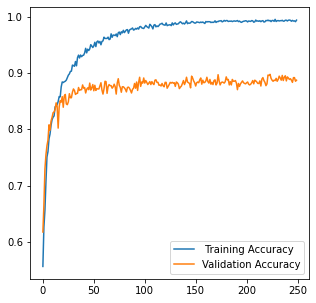

In [31]:
hist = pd.DataFrame(history.history)

#plot training and validation accuracy
f = plt.figure(figsize=(5,5))
plt.plot(hist["accuracy"], label =' Training Accuracy')
plt.plot(hist["val_accuracy"], label = 'Validation Accuracy')
plt.legend(loc="lower right")
plt.show()

# Save and output
file_name = f"enitity_extraction_training_validation_accuracy_{CONFIGURATION_LABEL}_epochs_{EPOCHS}_{TIME_STAMP}.png"
path = os.path.join(path_dir_data, subfolder_a, subfolder_entity, file_name)
f.savefig(path)
# f.download(path)

### Loss

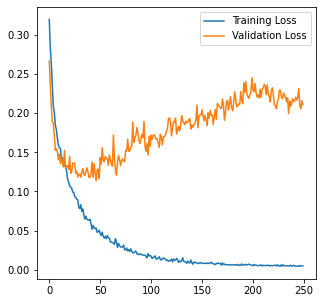

In [32]:
# plot training and validation accuracy
f = plt.figure(figsize=(5,5))
plt.plot(hist["loss"], label = 'Training Loss')
plt.plot(hist["val_loss"], label = 'Validation Loss')
plt.legend(loc="upper right")
plt.show()

# Save and output
file_name = f"enitity_extraction_training_validation_loss_{CONFIGURATION_LABEL}_epochs_{EPOCHS}_{TIME_STAMP}.png"
path = os.path.join(path_dir_data, subfolder_a, subfolder_entity, file_name)
f.savefig(path)
# f.download(path)

## Confusion Matrix

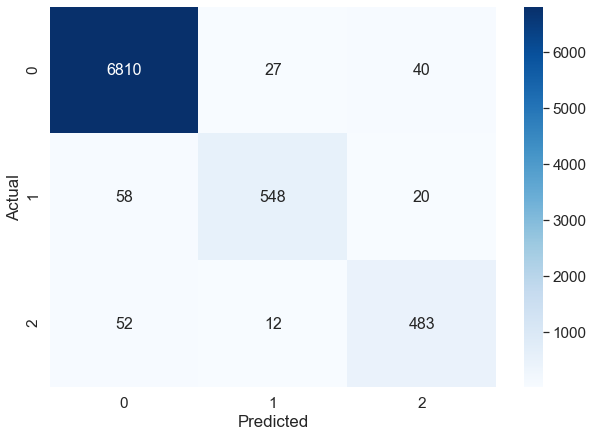

In [33]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Visualize
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True , fmt='d', annot_kws={"size": 16}) ;# font size

# Save and Restore Model
The following section tests saving and restoring the model.

## Save

In [34]:
# Export Model
folder_keras_model = f"entity_extraction_epoch_{CONFIGURATION_LABEL}_epochs_{EPOCHS}_{TIME_STAMP}"
path_keras_model = os.path.join(
    path_dir_data, subfolder_a, subfolder_entity, folder_keras_model
)

# SavedModel
model.save(path_keras_model)

INFO:tensorflow:Assets written to: ./../data\outputs\entity_extraction\entity_extraction_epoch_optimal_epochs_250_20210310-101431\assets


# Restore

In [35]:
from tensorflow import keras
model = keras.models.load_model(path_keras_model)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embeddings_glove (Embedding) (None, 50, 100)           100200    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           197632    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 3)             771       
Total params: 332,651
Trainable params: 332,651
Non-trainable params: 0
__________________________________________________